In [35]:
from pyrosm import OSM, get_data
import pyrosm
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Initialize the reader
osm = OSM('../data/planet_4.2624,50.357_4.5933,50.4882.osm.pbf') # downloaded from BBBike

In [2]:
source_address = "Rue Turenne 11, Charleroi"

In [3]:
# Get all walkable roads and the nodes 
nodes, edges = osm.get_network(nodes=True)

# Check first rows in the edge 
edges.head()

,access,bicycle,bridge,busway,cycleway,foot,footway,highway,int_ref,junction,...,width,id,timestamp,version,tags,osm_type,geometry,u,v,length
0,None,None,None,None,None,None,None,primary,None,roundabout,...,None,197574,0,0,"{""visible"":false,""maxspeed:type"":""sign""}",way,"LINESTRING (4.52797 50.45663, 4.52794 50.45655)",1547383,1103037320,8.730
1,None,None,None,None,None,None,None,primary,None,roundabout,...,None,197574,0,0,"{""visible"":false,""maxspeed:type"":""sign""}",way,"LINESTRING (4.52794 50.45655, 4.52794 50.45648)",1103037320,38464169,8.488
2,None,None,None,None,None,None,None,trunk,None,None,...,None,4309819,0,0,"{""visible"":false,""destination"":""Gosselies"",""op...",way,"LINESTRING (4.52831 50.45680, 4.52819 50.45682)",1547382,9630157482,8.603
3,None,None,None,None,None,None,None,trunk,None,None,...,None,4309819,0,0,"{""visible"":false,""destination"":""Gosselies"",""op...",way,"LINESTRING (4.52819 50.45682, 4.52809 50.45685)",9630157482,9630157485,8.411
4,None,None,None,None,None,None,None,trunk,None,None,...,None,4309819,0,0,"{""visible"":false,""destination"":""Gosselies"",""op...",way,"LINESTRING (4.52809 50.45685, 4.52799 50.45694)",9630157485,1152757218,11.788


In [4]:
# Create NetworkX graph
G = osm.to_graph(nodes, edges, graph_type="networkx")

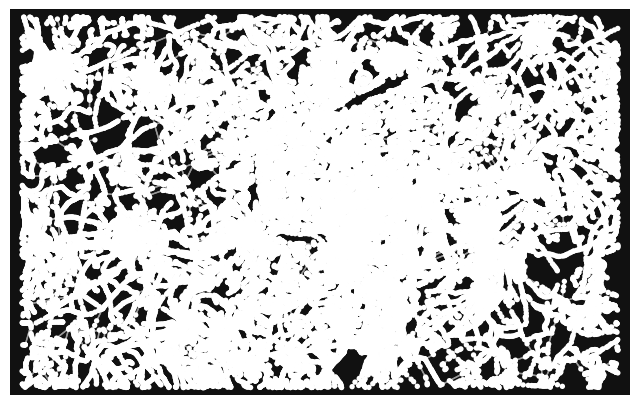

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph(G)

In [6]:
source = ox.geocode(source_address)

In [7]:
# Find the closest nodes from the graph
source_node = ox.nearest_nodes(G, source[1], source[0])

In [8]:
source_node

5523847758

In [24]:
trip_times = [5,10,15,20,25,30,35,40,45] # in minutes
travel_speed = 4.5 # kph
meters_per_minute = travel_speed * 1000 / 60 
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [ ]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, source_node, radius=trip_time,  distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [1 if node in node_colors else 0 for node in G.nodes()]

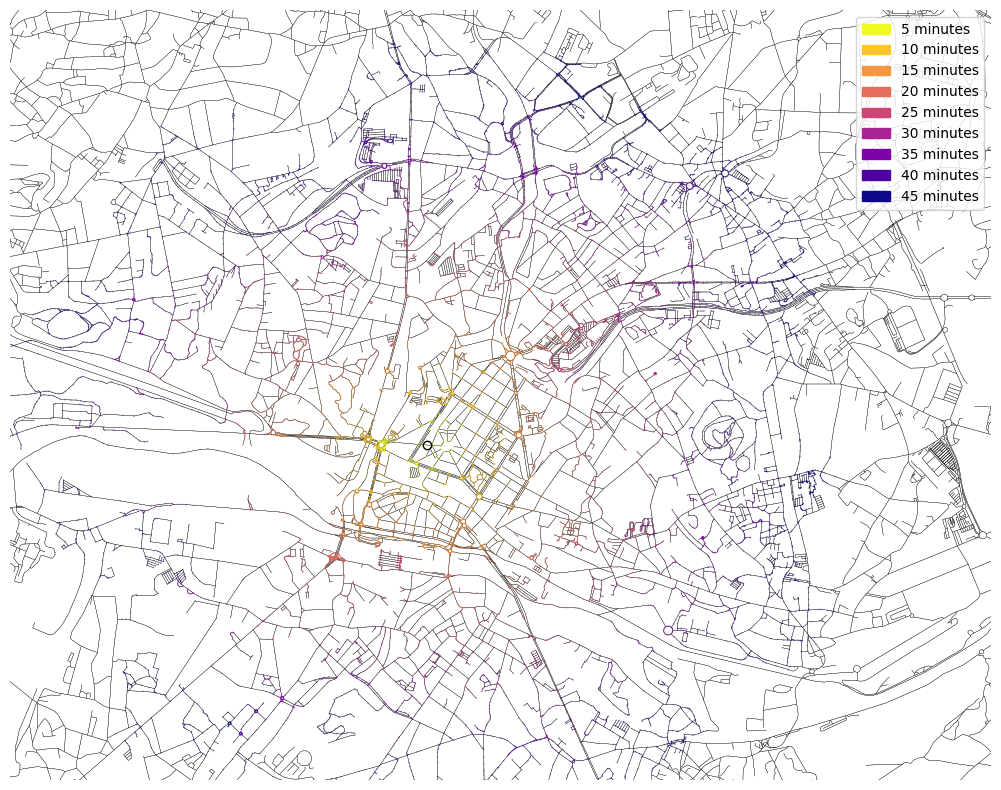

In [80]:
# plot map 
legend_patches = []
for idx, c in enumerate(reversed(iso_colors)):
    legend_patches.append(mpatches.Patch(color=c, label=f'{trip_times[idx]} minutes'))
fig, ax = plt.subplots(figsize=(20, 10))
ox.plot_graph(G, ax=ax, node_color=nc, node_size=ns, node_alpha=0.5, node_zorder=2, bgcolor='w', edge_linewidth=0.2, edge_color='k', show=False, close=False)
ax.plot(G.nodes[source_node]['x'], G.nodes[source_node]['y'], 'o', markerfacecolor=(0,0,0,0), markeredgecolor=(0,0,0,1))
ax.set_xlim(4.4,4.5)
ax.set_ylim(50.39,50.44)
ax.legend(handles=legend_patches, loc='upper right')